In [ ]:
# Build a simple back propagation neural network from scratch in Python for digit recognition 

In [ ]:
"""
Competition Description

MNIST ("Modified National Institute of Standards and Technology") 
is the de facto “hello world” dataset of computer vision. 
Since its release in 1999, this classic dataset of handwritten 
images has served as the basis for benchmarking classification algorithms. 
As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.
"""

In [ ]:
# We will be using the approach from Andrew Ng's ML course on Coursera for building the network

In [1]:
# intial imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#read the training data and store it into a dataframe
df = pd.read_csv(r'C:\Users\Legion\Desktop\kaggle_mnist\train.csv')

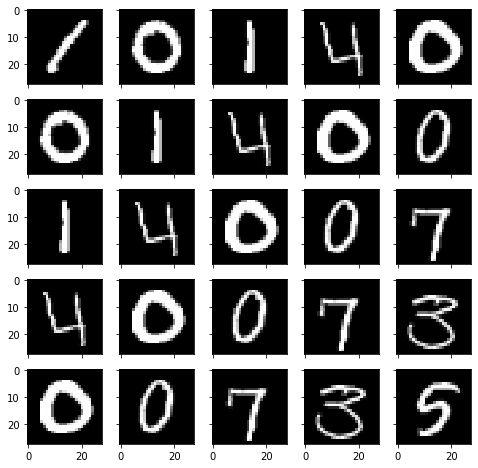

In [3]:
#the dataset consists of 28x28 pixels images of hand written digits
#let's take a look at a  few of them by reconstructing the image from the values stored for each pixel
img1 = df.iloc[:28,1:].values
fig, ax = plt.subplots(nrows=5,ncols=5,sharey = True, sharex = True)
fig.set_figwidth(8)
fig.set_figheight(8)
for i in range(5):
  for j in range(5):
    img = img1[i+j].reshape(28,28)
    ax[i,j].imshow(img, cmap='gray')

In [4]:
# splitting the features from the labels
X, y = df.iloc[:,1:], df.iloc[:,0]

In [5]:
#make y a column vector
y=np.c_[y]

In [6]:
# normalization of the train data ( RGB values go from 0 to 255)
X = X  / 255

In [7]:
#check the dimensions
print(X.shape)
print(y.shape)

(42000, 784)
(42000, 1)


In [8]:
#we are going to build a neural network consisting of 3 layers : input, hidden and output layer
#the input layer is going to be of size 784 neurons(24 * 24)
#the output layer is going to be of size 10 neurons (10 digits from 0 to 9)
#for the number of neurons for the hidden layer we are going to use the mean of the input and out put layer (~ 400 )
input_layer_size = 784
hidden_layer_size = 400
num_labels = 10

In [9]:
#the activation function we are going to use is the sigmoid
#let's create it now
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [10]:
#since we are going to use backpropagation to train the neural network we are going to first
#initialize the weights such that we break symmetry
#let's set the seed 
np.random.seed(0)

In [11]:
#create a function which assigns small random values for the neurons weights
def randInitializeWeights(L_in, L_out):
  epsilon_init = 0.5
  Theta = np.random.rand(L_out, L_in +1)*2*epsilon_init - epsilon_init
  return Theta

In [12]:
# create a function to compute the gradient of the sigmoid function
def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

In [13]:
# below we will create a function to calculate both the gradient and the cost function for the neural network

def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):

    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    # m - number of training examples
    m = X.shape[0]
    J=0
    # add biases to X
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    # forward propagation
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] 
        a1i = a1[i,:] 
        a2i =a2[i,:] 
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg


In [14]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):

    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
        print("Cost function at iteration " ,i+1 , "is " ,J_history[-1])
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [24]:
# initialize the parameters
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [25]:
nnTheta, nnJ_history = gradientDescentnn(X,y,nn_params,0.15,50,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Cost function at iteration  1 is  15.263227950657445
Cost function at iteration  2 is  9.221725866498506
Cost function at iteration  3 is  7.50929879294876
Cost function at iteration  4 is  5.955940206777042
Cost function at iteration  5 is  4.728695507020319
Cost function at iteration  6 is  3.856351894454332
Cost function at iteration  7 is  3.4227144979626525
Cost function at iteration  8 is  3.2709226382728414
Cost function at iteration  9 is  3.1497105318930085
Cost function at iteration  10 is  3.0389942449552385
Cost function at iteration  11 is  2.937767187232372
Cost function at iteration  12 is  2.845244072154455
Cost function at iteration  13 is  2.7606589617513784
Cost function at iteration  14 is  2.683277720858859
Cost function at iteration  15 is  2.612384956539412
Cost function at iteration  16 is  2.547314321539101
Cost function at iteration  17 is  2.4874513348795286
Cost function at iteration  18 is  2.432242617263984
Cost function at iteration  19 is  2.381193868862

In [26]:
def predict(Theta1, Theta2, X):

    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) 
    a2 = sigmoid(a1 @ Theta2.T) 
    
    return np.argmax(a2,axis=1)+1

In [28]:
df_test = pd.read_csv(r'C:\Users\Legion\Desktop\kaggle_mnist\test.csv')

In [29]:
df_test = df_test/255

In [30]:
predictions = predict(Theta1, Theta2, df_test)

In [31]:
predictions = np.where(predictions==10,0,predictions)

In [32]:
np.savetxt("nn_predictions.csv", predictions, delimiter=",")

In [ ]:
# The out of sample accuracy was of 68%